# Problem 2: Generative Adversarial Networks

* **Learning Objective:** In this problem, you will implement a Generative Adversarial Network with the network structure proposed in [*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks*](https://arxiv.org/abs/1511.06434), and learn a visualization technique, *activation maximization*.
* **Provided code:** The code for constructing the two parts of the GAN, the discriminator and the generator, is done for you, along with the skeleton code for the training.
* **TODOs:** You will need to figure out how to properly feed the data, compute the loss and update the parameters to complete the training and visualization. In addition, to test your understanding, you will answer some non-coding questions.

In [6]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction: The forger versus the police

*Note: read the story even if you are already familiar with GANs, as one of the questions is related to this story.*

Generative models try to model the distribution of the data in an explicit way, in the sense that we can easily sample new data points from this model. This is in contrast to discriminative models that try to infer the output from the input. In the class we have seen one classic deep generative model, the Variational Autoencoder (VAE). Here, we will learn another generative model that has risen to prominence in recent years, the Generative Adversarial Network (GAN).

As the maths of Generative Adversarial Networks is somewhat tedious, a story is often told of a forger and a police to illustrate the idea.

> Imagine a forger that makes fake bills, and a police that tries to find these forgeries. If the forger were a VAE, his goal would be to take some real bills, and try to replicate the real bills as precisely as possible. In GAN, he has a different idea in his mind: rather than trying to replicate the real bills, it suffices to make fake bills such that people *think* they are real.
> 
> Now let's start. In the beginning, the police knows nothing about how to distinguish between real and fake bills. The forger knows nothing either and only produces white paper.
> 
> In the first round, the police gets the fake bill and learns that the forgeries are white while the real bills are green. The forger then finds out that white papers can no longer fool the police and starts to produce green papers.
>
> In the second round, the police learns that real bills have denominations printed on them while the forgeries do not. The forger then finds out that plain papers can no longer fool the police and starts to print numbers on them.
>
> In the third round, the police learns that real bills have watermarks on them while the forgeries do not. The forger then has to reproduce the watermarks on his fake bills.
>
> ...
>
> Finally, the police is able to spot the tiniest difference between real and fake bills and the forger has to make perfect replicas of real bills to fool the police.

Now in a GAN, the forger becomes the generator and the police becomes the discriminator. The discriminator is a binary classifier with the two classes being "taken from the real data" ("real") and "generated by the generator" ("fake"). Its objective is to minimize the classification loss. The generator's objective is to generate samples so that the discriminator misclassifies them as real.

Here we have some complications: the goal is not to find one perfect fake sample. Such a sample will not actually fool the discriminator: if the forger makes hundreds of the exact same fake bill, they will all have the same serial number and the police will soon find out that they are fake. Instead, we want the generator to be able to generate a variety of fake samples such that when presented as a distribution alongside the distribution of real samples, these two are indistinguishable by the discriminator.

So how do we generate different samples with a diterministic generator? We provide it with random numbers as input.

Typically, for the discriminator we use binary cross entropy loss with label 1 being real and 0 being fake. For the generator, the input is a random vector drawn from a standard normal distribution. Denote the generator by $G_{\phi}(z)$, discriminator by $D_{\theta}(x)$, the distribution of the real samples by $p(x)$ and the input distribution to the generator by $q(z)$. Recall that the binary cross entropy loss with classifier output $y$ and label $\hat{y}$ is

$$L(y, \hat{y}) = -\hat{y} \log y - (1 - \hat{y}) \log (1 - y)$$

For the discriminator, the objective is

$$\min_{\theta} \mathrm{E}_{x \sim p(x)}[L(D_{\theta}(x), 1)] + \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

For the generator, the objective is

$$\max_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 0)]$$

The generator's objective corresponds to maximizing the classification loss of the discriminator on the generated samples. Alternatively, we can **minimize** the classification loss of the discriminator on the generated samples  **when labelled as real**:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

And this is what we will use in our implementation. The strength of the two networks should be balanced, so we train the two networks alternatingly, updating the parameters in both networks once in each interation.

## Problem 2-1: Implementing the GAN (30 pts)

We first load the data (CIFAR-10) and define some convenient functions. You should already have CIFAR-10 from assignment 1. Just copy the data from there or use ```data/get_datasets.sh``` if you don't have them.

In [7]:
def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    X = []
    for i in range(5):
        X_, _ = unpickle('data/cifar-10-batches-py/data_batch_%d' % (i + 1))
        X.append(X_)
    X = np.concatenate(X)
    X = X.reshape((X.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

def load_test_data():
    X_, _ = unpickle('data/cifar-10-batches-py/test_batch')
    X = X_.reshape((X_.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1)
    return X

# Load cifar-10 data
train_samples = load_train_data() / 255.0
test_samples = load_test_data() / 255.0

In [8]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def set_seed(seed):
    np.random.seed(seed)
    tf.set_random_seed(seed)

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

To save you some mundane work, we have defined a discriminator and a generator for you, in ```_discriminator()``` and ```_generator()``` respectively. Look at the code to see what layers are there.

For this part, you need to complete code blocks marked with "Prob 2-1":

*   **Build the computation graph for the losses:** Complete the following definitions in ```_init_ops()```
    *   ```fake_samples_op```: generate famples from ```noise```
    *   ```dis_loss_op```: compute discriminator's loss, with real samples from ```real_input``` and fake
        samples generated by the generator
    *   ```gen_loss_op```: compute generator's loss
*   **Define the optimizer:** We use RMSprop for training. Adam is observed to perform poorly with an unstable objective as is the case in GANs. We've defined ```dis_train_op``` and ```gen_train_op``` for you but those are wrong: rather than updating all the parameters all the time, when training one network we want to keep the other one fixed. Modify the definition to reflect this. [Check here](https://stackoverflow.com/a/35304001) if you are not sure how this is possible.
*   **Feed the data:** Feed the proper samples and labels in ```train()``` for training and in ```generate_one_sample()``` for visualizing the generated samples.

The batch normalization layers should operate in training mode. As per *[How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)*, we put real samples and fake samples in different batches when training the discriminator.

*Note: use the advices on that page with caution if you are doing GAN for your team project. It is already more than 2 years old, which is a **really long time** in deep learning research. It does not reflect the latest results.*

In [58]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 15
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 64
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 200
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False

        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, input):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(input, 4, 2, 32, 'conv1')
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
            dis_fc4 = fc(dis_reshape3, 1, 'fc4')
            return dis_fc4

    def _generator(self, input):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            gen_fc1 = fc(input, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        
        self.fake_samples_op = self._generator(self.noise)
        self.dis_loss_op = self._loss(logits=self._discriminator(self.real_input),labels=self.real_label)+self._loss(logits=self._discriminator(self.fake_samples_op),labels=self.fake_label)
        self.gen_loss_op = self._loss(logits=self._discriminator(self.fake_samples_op),labels=self.fake_label)
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        
        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op, var_list = dis_var_list)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op, var_list = gen_var_list)
        
        ################################################################################
        # Prob 2-2: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code)
        actmax_dis = self._discriminator(self.actmax_sample_op)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-2: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        self.recon_loss_op = self._reconstruction_loss(generated=self.actmax_sample_op, target=self.recon_sample)        
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples):
        sess.run(tf.global_variables_initializer())

        num_train = train_samples.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        max_steps = int(self.num_epoch * (num_train // self.batch_size))
        print('Start training ...')
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_samples = train_samples[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                dis_feed_dict = {self.noise:noise,self.real_input:batch_samples,self.is_train:True,self.real_label:zeros,self.fake_label:ones}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                gen_feed_dict = {self.noise:noise,self.is_train:True,self.fake_label:zeros}
                
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}/{1}: dis loss = {2:.4f}, gen loss = {3:.4f}'.format(step, max_steps, dis_loss, gen_loss))

            fig = plt.figure(figsize = (8, 8))   
            ax1 = plt.subplot(111)
            ax1.imshow(viz_grid(self.generate(self.tracked_noise), 1))
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
        print('... Done!')

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-2: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        actmax_init_val = tf.zeros_like(self.actmax_code)
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-2: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-2     #
            ################################################################################   
            
            recon_feed_dict = {self.recon_sample:sample, self.is_train:False}
            
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################
        
        gen_vis_feed_dict = {self.noise:code,self.is_train:False}
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes):
        generated = np.zeros((codes.shape[0], 32, 32, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1])
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-2: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-2     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

Now let's do the training!

Don't panic if the loss curve goes wild. The two networks are competing for the loss curve to go different directions, so virtually anything can happen. If your code is correct, the generated samples should have a high variety.

Start training ...
Iteration 50/23430: dis loss = 0.4115, gen loss = 2.1116
Iteration 100/23430: dis loss = 0.0745, gen loss = 3.9517
Iteration 150/23430: dis loss = 0.2295, gen loss = 4.9602
Iteration 200/23430: dis loss = 0.2216, gen loss = 2.9517
Iteration 250/23430: dis loss = 0.0608, gen loss = 4.3127
Iteration 300/23430: dis loss = 0.7495, gen loss = 0.9108
Iteration 350/23430: dis loss = 0.6731, gen loss = 1.8117
Iteration 400/23430: dis loss = 0.8114, gen loss = 1.2094
Iteration 450/23430: dis loss = 0.4989, gen loss = 1.4818
Iteration 500/23430: dis loss = 1.0625, gen loss = 0.4485
Iteration 550/23430: dis loss = 1.0900, gen loss = 1.4252
Iteration 600/23430: dis loss = 0.8598, gen loss = 1.9752
Iteration 650/23430: dis loss = 1.1305, gen loss = 0.3981
Iteration 700/23430: dis loss = 1.1549, gen loss = 0.7515
Iteration 750/23430: dis loss = 0.8502, gen loss = 1.2253
Iteration 800/23430: dis loss = 0.8512, gen loss = 2.1686
Iteration 850/23430: dis loss = 0.8410, gen loss = 1.4

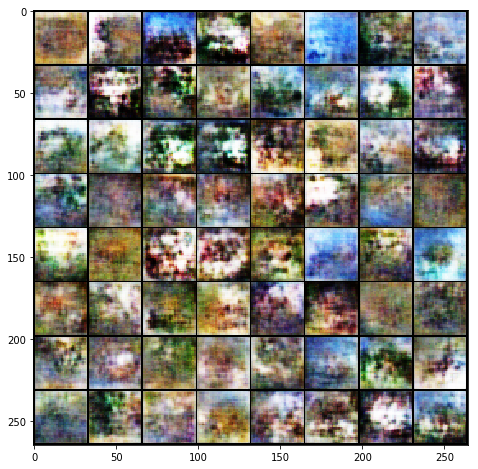

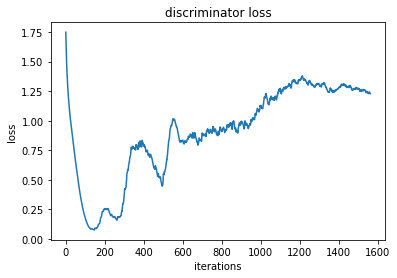

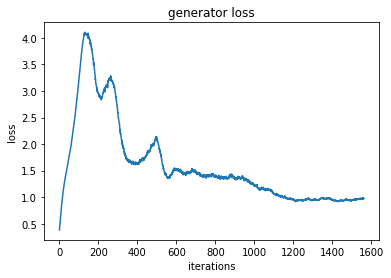

Iteration 1600/23430: dis loss = 1.0398, gen loss = 1.1360
Iteration 1650/23430: dis loss = 1.2708, gen loss = 1.3192
Iteration 1700/23430: dis loss = 1.2567, gen loss = 1.3094
Iteration 1750/23430: dis loss = 1.1155, gen loss = 0.7809
Iteration 1800/23430: dis loss = 1.2995, gen loss = 0.7501
Iteration 1850/23430: dis loss = 1.2180, gen loss = 0.6483
Iteration 1900/23430: dis loss = 1.1067, gen loss = 1.1062
Iteration 1950/23430: dis loss = 1.1504, gen loss = 0.9150
Iteration 2000/23430: dis loss = 1.0760, gen loss = 1.0929
Iteration 2050/23430: dis loss = 1.2264, gen loss = 1.0290
Iteration 2100/23430: dis loss = 1.2725, gen loss = 0.7761
Iteration 2150/23430: dis loss = 1.2506, gen loss = 0.6816
Iteration 2200/23430: dis loss = 1.0962, gen loss = 1.1610
Iteration 2250/23430: dis loss = 1.1636, gen loss = 0.6775
Iteration 2300/23430: dis loss = 1.2169, gen loss = 1.1553
Iteration 2350/23430: dis loss = 0.9735, gen loss = 1.1604
Iteration 2400/23430: dis loss = 1.2789, gen loss = 0.58

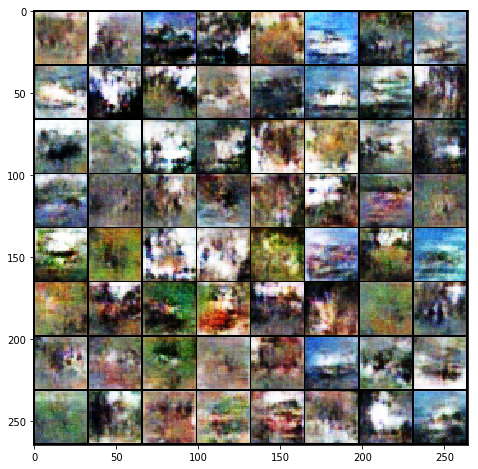

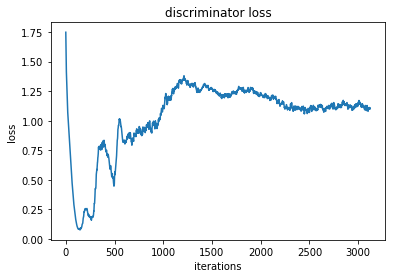

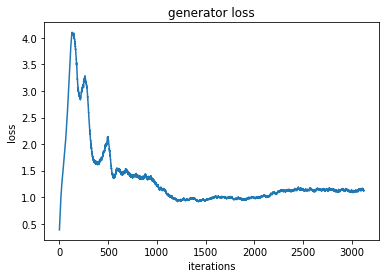

Iteration 3150/23430: dis loss = 1.1890, gen loss = 0.8950
Iteration 3200/23430: dis loss = 0.9696, gen loss = 1.2351
Iteration 3250/23430: dis loss = 1.0220, gen loss = 1.7387
Iteration 3300/23430: dis loss = 0.9700, gen loss = 1.6214
Iteration 3350/23430: dis loss = 1.1819, gen loss = 1.1982
Iteration 3400/23430: dis loss = 1.3072, gen loss = 1.2639
Iteration 3450/23430: dis loss = 0.9165, gen loss = 1.5373
Iteration 3500/23430: dis loss = 1.2425, gen loss = 0.5429
Iteration 3550/23430: dis loss = 0.9023, gen loss = 1.2677
Iteration 3600/23430: dis loss = 1.0453, gen loss = 0.8777
Iteration 3650/23430: dis loss = 1.1226, gen loss = 1.5159
Iteration 3700/23430: dis loss = 0.9818, gen loss = 1.0860
Iteration 3750/23430: dis loss = 1.0756, gen loss = 0.9650
Iteration 3800/23430: dis loss = 1.0570, gen loss = 0.6952
Iteration 3850/23430: dis loss = 0.9284, gen loss = 0.9769
Iteration 3900/23430: dis loss = 0.8873, gen loss = 0.9666
Iteration 3950/23430: dis loss = 1.0214, gen loss = 0.98

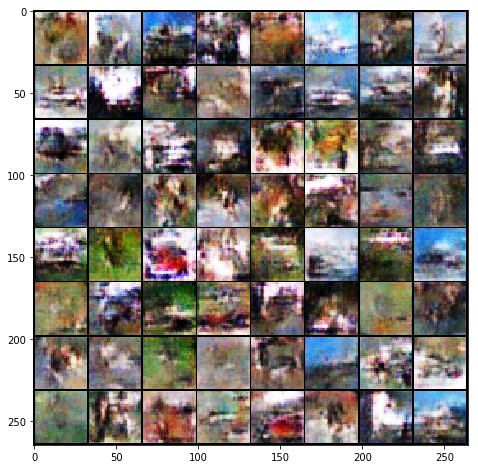

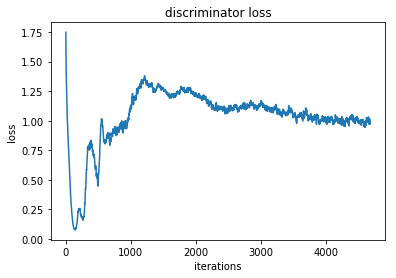

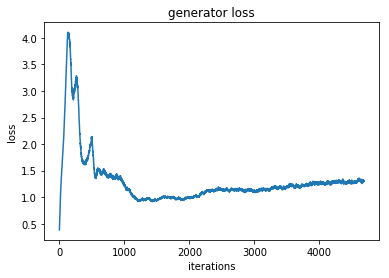

Iteration 4700/23430: dis loss = 1.3967, gen loss = 0.4897
Iteration 4750/23430: dis loss = 1.1247, gen loss = 1.0920
Iteration 4800/23430: dis loss = 1.0671, gen loss = 0.9631
Iteration 4850/23430: dis loss = 0.9677, gen loss = 1.7068
Iteration 4900/23430: dis loss = 1.2320, gen loss = 0.6651
Iteration 4950/23430: dis loss = 0.9953, gen loss = 0.7867
Iteration 5000/23430: dis loss = 0.9184, gen loss = 1.3938
Iteration 5050/23430: dis loss = 0.9769, gen loss = 0.7800
Iteration 5100/23430: dis loss = 1.0405, gen loss = 1.9289
Iteration 5150/23430: dis loss = 0.9489, gen loss = 1.0749
Iteration 5200/23430: dis loss = 1.0790, gen loss = 1.1844
Iteration 5250/23430: dis loss = 0.9591, gen loss = 1.6577
Iteration 5300/23430: dis loss = 1.1956, gen loss = 1.8341
Iteration 5350/23430: dis loss = 1.1263, gen loss = 0.6042
Iteration 5400/23430: dis loss = 1.0915, gen loss = 2.1503
Iteration 5450/23430: dis loss = 1.1009, gen loss = 2.3953
Iteration 5500/23430: dis loss = 0.9071, gen loss = 1.07

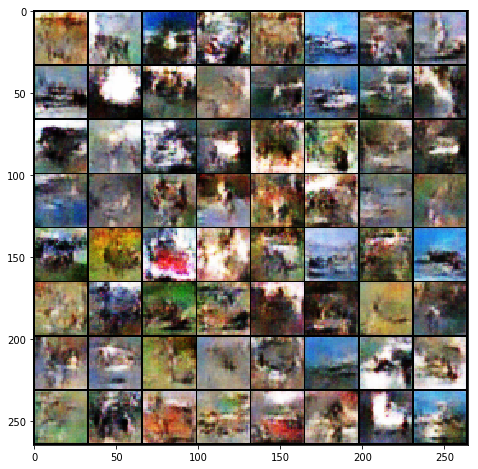

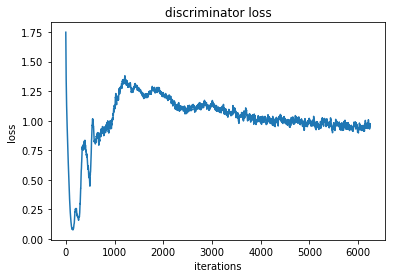

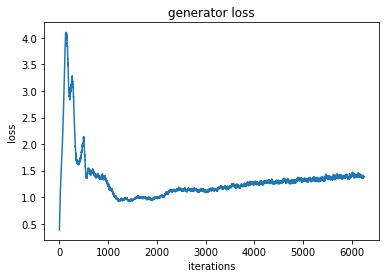

Iteration 6250/23430: dis loss = 1.2152, gen loss = 0.8298
Iteration 6300/23430: dis loss = 1.0197, gen loss = 0.9616
Iteration 6350/23430: dis loss = 0.7743, gen loss = 1.5685
Iteration 6400/23430: dis loss = 0.9088, gen loss = 1.5664
Iteration 6450/23430: dis loss = 0.8381, gen loss = 1.4806
Iteration 6500/23430: dis loss = 0.8040, gen loss = 1.2286
Iteration 6550/23430: dis loss = 1.5553, gen loss = 0.4591
Iteration 6600/23430: dis loss = 0.9773, gen loss = 1.3599
Iteration 6650/23430: dis loss = 1.5013, gen loss = 0.6857
Iteration 6700/23430: dis loss = 1.0884, gen loss = 2.0071
Iteration 6750/23430: dis loss = 0.8319, gen loss = 1.8614
Iteration 6800/23430: dis loss = 0.8891, gen loss = 1.1206
Iteration 6850/23430: dis loss = 0.8505, gen loss = 1.5394
Iteration 6900/23430: dis loss = 0.8975, gen loss = 1.9440
Iteration 6950/23430: dis loss = 0.7118, gen loss = 1.0063
Iteration 7000/23430: dis loss = 1.1688, gen loss = 0.7823
Iteration 7050/23430: dis loss = 1.1855, gen loss = 2.42

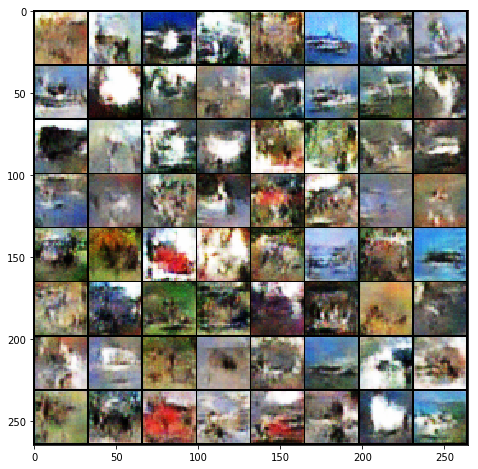

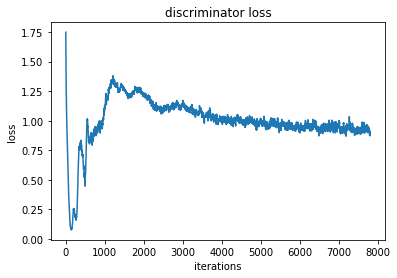

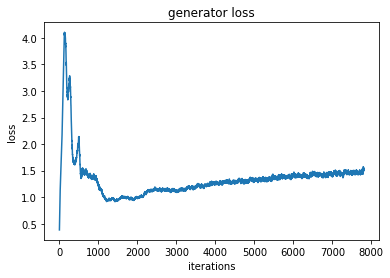

Iteration 7850/23430: dis loss = 1.1849, gen loss = 0.4894
Iteration 7900/23430: dis loss = 0.9897, gen loss = 2.5853
Iteration 7950/23430: dis loss = 0.9825, gen loss = 1.7476
Iteration 8000/23430: dis loss = 0.9936, gen loss = 0.7214
Iteration 8050/23430: dis loss = 0.8350, gen loss = 2.3760
Iteration 8100/23430: dis loss = 0.9431, gen loss = 1.7465
Iteration 8150/23430: dis loss = 0.8661, gen loss = 1.6997
Iteration 8200/23430: dis loss = 0.8446, gen loss = 1.9118
Iteration 8250/23430: dis loss = 1.1370, gen loss = 2.7829
Iteration 8300/23430: dis loss = 0.7565, gen loss = 1.3395
Iteration 8350/23430: dis loss = 1.0322, gen loss = 0.6525
Iteration 8400/23430: dis loss = 0.8264, gen loss = 1.0607
Iteration 8450/23430: dis loss = 1.0497, gen loss = 2.2703
Iteration 8500/23430: dis loss = 1.1523, gen loss = 2.5291
Iteration 8550/23430: dis loss = 1.3849, gen loss = 0.7903
Iteration 8600/23430: dis loss = 1.1044, gen loss = 2.5012
Iteration 8650/23430: dis loss = 0.9163, gen loss = 1.49

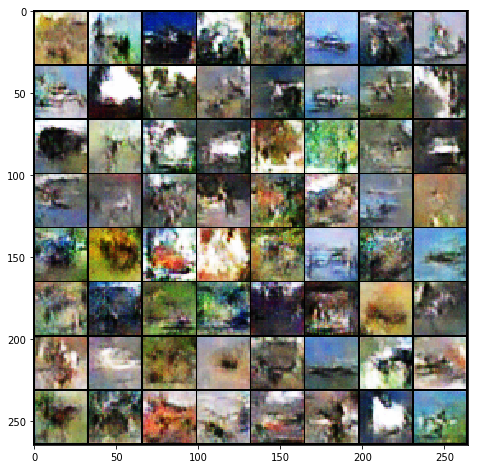

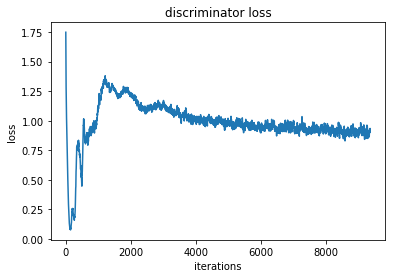

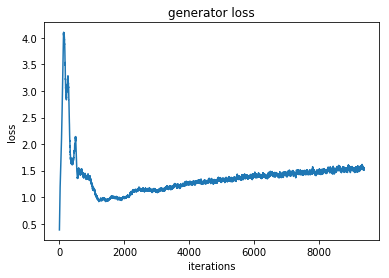

Iteration 9400/23430: dis loss = 1.1173, gen loss = 0.8306
Iteration 9450/23430: dis loss = 1.0026, gen loss = 2.3363
Iteration 9500/23430: dis loss = 0.7337, gen loss = 1.9779
Iteration 9550/23430: dis loss = 0.8728, gen loss = 1.1027
Iteration 9600/23430: dis loss = 0.7014, gen loss = 1.5314
Iteration 9650/23430: dis loss = 0.9474, gen loss = 1.0693
Iteration 9700/23430: dis loss = 0.7041, gen loss = 1.9577
Iteration 9750/23430: dis loss = 0.5333, gen loss = 2.1123
Iteration 9800/23430: dis loss = 0.9258, gen loss = 2.3324
Iteration 9850/23430: dis loss = 0.9519, gen loss = 0.6089
Iteration 9900/23430: dis loss = 0.5715, gen loss = 1.4802
Iteration 9950/23430: dis loss = 0.9905, gen loss = 2.4798
Iteration 10000/23430: dis loss = 0.8126, gen loss = 1.4161
Iteration 10050/23430: dis loss = 0.8664, gen loss = 0.9326
Iteration 10100/23430: dis loss = 1.0043, gen loss = 1.7370
Iteration 10150/23430: dis loss = 0.9517, gen loss = 2.2659
Iteration 10200/23430: dis loss = 0.9856, gen loss =

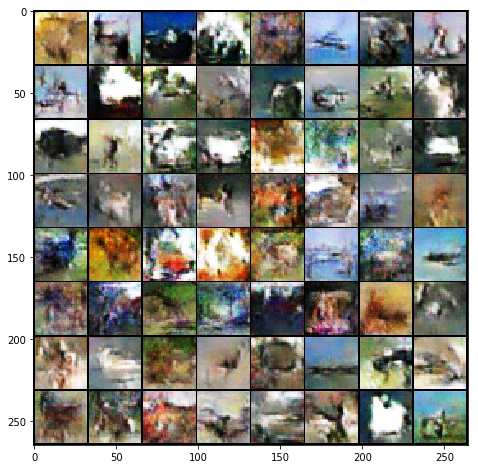

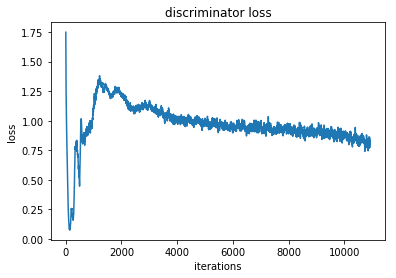

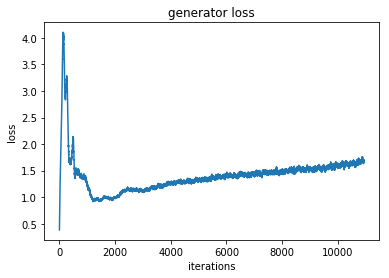

Iteration 10950/23430: dis loss = 0.7365, gen loss = 1.5104
Iteration 11000/23430: dis loss = 0.8476, gen loss = 0.6787
Iteration 11050/23430: dis loss = 0.9920, gen loss = 2.6245
Iteration 11100/23430: dis loss = 0.6959, gen loss = 1.6777
Iteration 11150/23430: dis loss = 1.1145, gen loss = 2.5698
Iteration 11200/23430: dis loss = 0.7776, gen loss = 1.2066
Iteration 11250/23430: dis loss = 0.4750, gen loss = 2.1178
Iteration 11300/23430: dis loss = 0.7457, gen loss = 1.5738
Iteration 11350/23430: dis loss = 0.7437, gen loss = 1.8199
Iteration 11400/23430: dis loss = 0.7055, gen loss = 0.9708
Iteration 11450/23430: dis loss = 1.0466, gen loss = 0.7553
Iteration 11500/23430: dis loss = 0.9681, gen loss = 2.6454
Iteration 11550/23430: dis loss = 0.6989, gen loss = 2.0837
Iteration 11600/23430: dis loss = 0.6247, gen loss = 2.3246
Iteration 11650/23430: dis loss = 1.1103, gen loss = 0.7612
Iteration 11700/23430: dis loss = 0.7620, gen loss = 2.4628
Iteration 11750/23430: dis loss = 0.7029

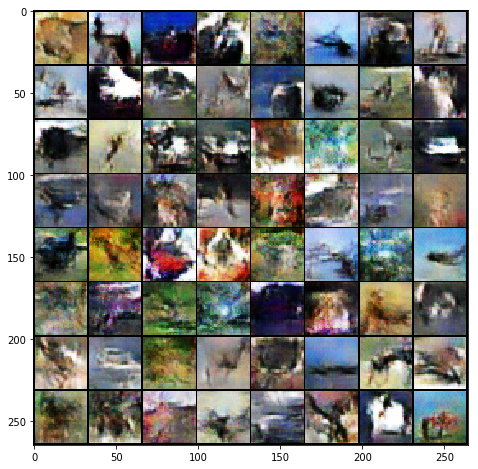

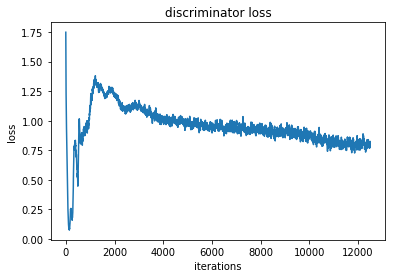

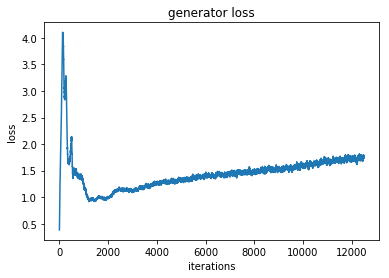

Iteration 12500/23430: dis loss = 0.8414, gen loss = 2.1169
Iteration 12550/23430: dis loss = 0.6919, gen loss = 1.4834
Iteration 12600/23430: dis loss = 1.0986, gen loss = 0.9971
Iteration 12650/23430: dis loss = 0.5793, gen loss = 1.9252
Iteration 12700/23430: dis loss = 0.7413, gen loss = 1.7292
Iteration 12750/23430: dis loss = 0.9456, gen loss = 2.4180
Iteration 12800/23430: dis loss = 0.6402, gen loss = 2.0361
Iteration 12850/23430: dis loss = 0.6692, gen loss = 1.9384
Iteration 12900/23430: dis loss = 0.7952, gen loss = 1.2369
Iteration 12950/23430: dis loss = 0.9177, gen loss = 0.8724
Iteration 13000/23430: dis loss = 0.9856, gen loss = 0.8537
Iteration 13050/23430: dis loss = 0.5749, gen loss = 1.9008
Iteration 13100/23430: dis loss = 0.5935, gen loss = 2.4203
Iteration 13150/23430: dis loss = 0.7368, gen loss = 2.4174
Iteration 13200/23430: dis loss = 0.7296, gen loss = 2.2094
Iteration 13250/23430: dis loss = 1.0104, gen loss = 0.8289
Iteration 13300/23430: dis loss = 0.7869

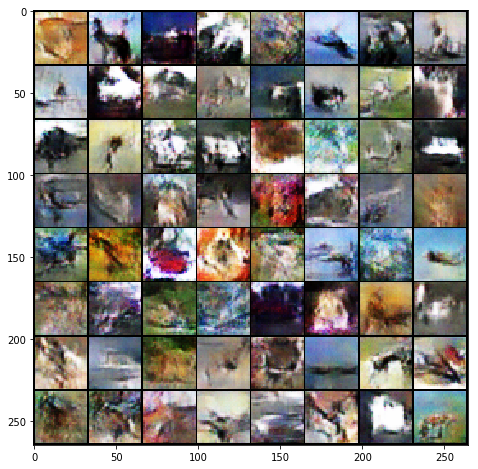

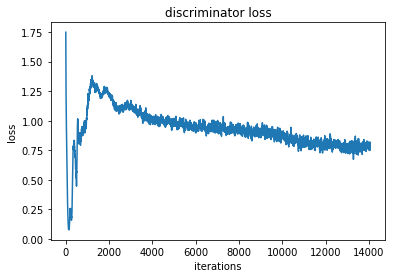

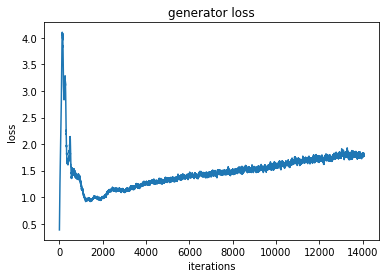

Iteration 14100/23430: dis loss = 1.0701, gen loss = 0.7070
Iteration 14150/23430: dis loss = 0.9297, gen loss = 1.4874
Iteration 14200/23430: dis loss = 1.1737, gen loss = 2.1270
Iteration 14250/23430: dis loss = 0.5583, gen loss = 2.3678
Iteration 14300/23430: dis loss = 0.7650, gen loss = 3.0820
Iteration 14350/23430: dis loss = 0.5536, gen loss = 2.0030
Iteration 14400/23430: dis loss = 0.6552, gen loss = 1.4586
Iteration 14450/23430: dis loss = 0.6556, gen loss = 1.0723
Iteration 14500/23430: dis loss = 0.5593, gen loss = 2.1532
Iteration 14550/23430: dis loss = 0.6538, gen loss = 1.4445
Iteration 14600/23430: dis loss = 0.5546, gen loss = 2.6352
Iteration 14650/23430: dis loss = 0.7171, gen loss = 1.3019
Iteration 14700/23430: dis loss = 0.7561, gen loss = 1.2339
Iteration 14750/23430: dis loss = 0.6173, gen loss = 1.7004
Iteration 14800/23430: dis loss = 0.6926, gen loss = 2.1480
Iteration 14850/23430: dis loss = 0.6161, gen loss = 2.7069
Iteration 14900/23430: dis loss = 0.8098

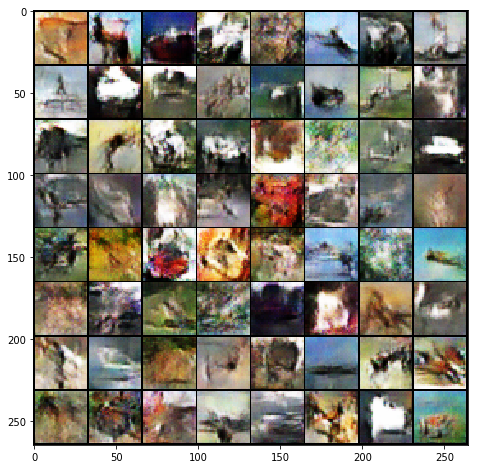

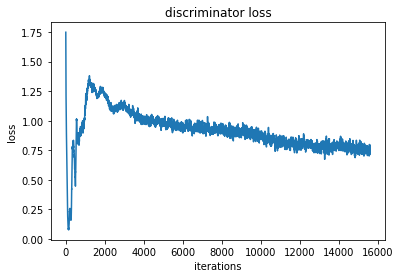

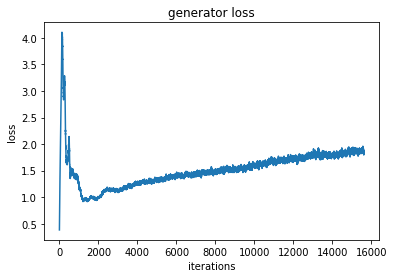

Iteration 15650/23430: dis loss = 0.8800, gen loss = 1.1112
Iteration 15700/23430: dis loss = 0.6523, gen loss = 2.6378
Iteration 15750/23430: dis loss = 0.5180, gen loss = 2.0129
Iteration 15800/23430: dis loss = 0.7159, gen loss = 1.4448
Iteration 15850/23430: dis loss = 0.6078, gen loss = 1.4800
Iteration 15900/23430: dis loss = 0.9015, gen loss = 2.2575
Iteration 15950/23430: dis loss = 0.4940, gen loss = 2.3843
Iteration 16000/23430: dis loss = 1.1197, gen loss = 2.5258
Iteration 16050/23430: dis loss = 0.6012, gen loss = 1.8768
Iteration 16100/23430: dis loss = 0.7989, gen loss = 0.8503
Iteration 16150/23430: dis loss = 0.6428, gen loss = 2.2865
Iteration 16200/23430: dis loss = 0.8704, gen loss = 1.8267
Iteration 16250/23430: dis loss = 0.8912, gen loss = 1.7649
Iteration 16300/23430: dis loss = 0.9112, gen loss = 1.2454
Iteration 16350/23430: dis loss = 0.6966, gen loss = 1.9821
Iteration 16400/23430: dis loss = 0.5002, gen loss = 2.6104
Iteration 16450/23430: dis loss = 0.6946

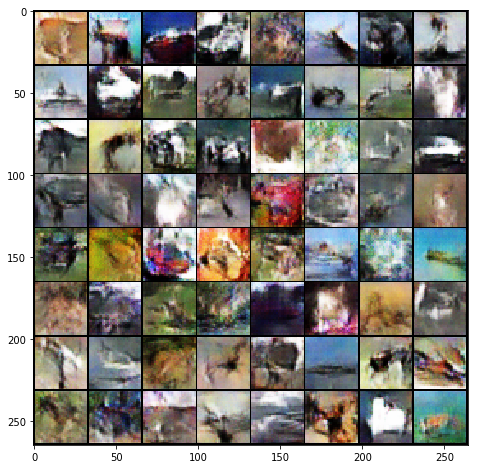

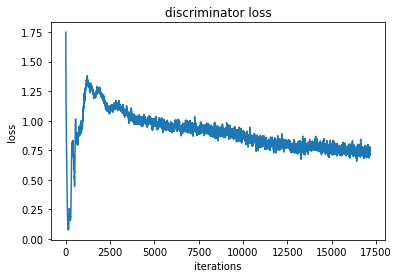

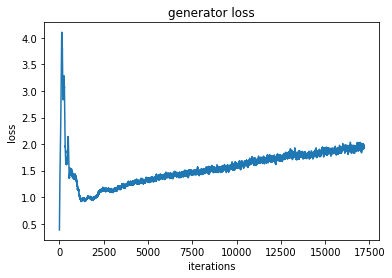

Iteration 17200/23430: dis loss = 0.6396, gen loss = 2.1994
Iteration 17250/23430: dis loss = 1.0852, gen loss = 3.1275
Iteration 17300/23430: dis loss = 0.5532, gen loss = 1.8360
Iteration 17350/23430: dis loss = 0.9875, gen loss = 0.6984
Iteration 17400/23430: dis loss = 0.5120, gen loss = 2.2781
Iteration 17450/23430: dis loss = 0.7555, gen loss = 1.1819
Iteration 17500/23430: dis loss = 0.8979, gen loss = 2.8613
Iteration 17550/23430: dis loss = 0.5746, gen loss = 3.0530
Iteration 17600/23430: dis loss = 0.5651, gen loss = 1.8196
Iteration 17650/23430: dis loss = 0.5345, gen loss = 1.9016
Iteration 17700/23430: dis loss = 0.7408, gen loss = 1.3730
Iteration 17750/23430: dis loss = 0.7799, gen loss = 0.8571
Iteration 17800/23430: dis loss = 0.5767, gen loss = 1.9527
Iteration 17850/23430: dis loss = 0.8534, gen loss = 2.1919
Iteration 17900/23430: dis loss = 1.5031, gen loss = 0.6728
Iteration 17950/23430: dis loss = 0.5529, gen loss = 1.9935
Iteration 18000/23430: dis loss = 1.1159

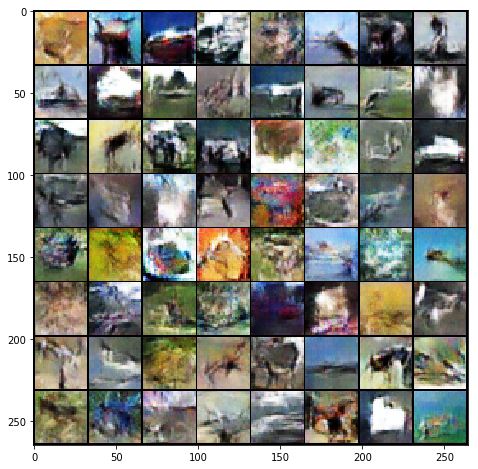

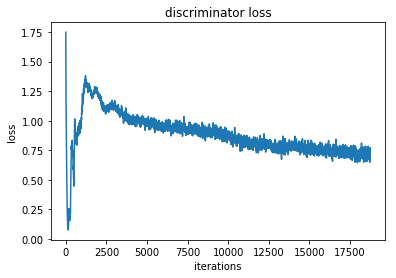

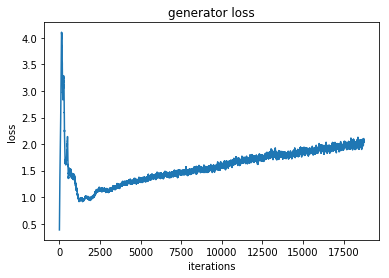

Iteration 18750/23430: dis loss = 0.6550, gen loss = 2.1465
Iteration 18800/23430: dis loss = 0.8357, gen loss = 3.3048
Iteration 18850/23430: dis loss = 0.8162, gen loss = 1.2586
Iteration 18900/23430: dis loss = 0.7094, gen loss = 1.3350
Iteration 18950/23430: dis loss = 0.8023, gen loss = 2.9995
Iteration 19000/23430: dis loss = 0.6029, gen loss = 1.6687
Iteration 19050/23430: dis loss = 0.5996, gen loss = 1.9230
Iteration 19100/23430: dis loss = 0.6231, gen loss = 1.8692
Iteration 19150/23430: dis loss = 0.6957, gen loss = 2.8159
Iteration 19200/23430: dis loss = 0.5952, gen loss = 2.5280
Iteration 19250/23430: dis loss = 0.7160, gen loss = 2.3985
Iteration 19300/23430: dis loss = 0.6028, gen loss = 2.2420
Iteration 19350/23430: dis loss = 0.4141, gen loss = 2.1281
Iteration 19400/23430: dis loss = 0.7982, gen loss = 1.4795
Iteration 19450/23430: dis loss = 0.7128, gen loss = 1.0738
Iteration 19500/23430: dis loss = 0.8225, gen loss = 1.1422
Iteration 19550/23430: dis loss = 0.5681

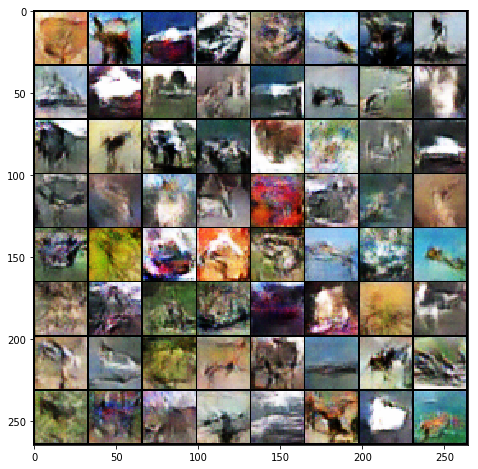

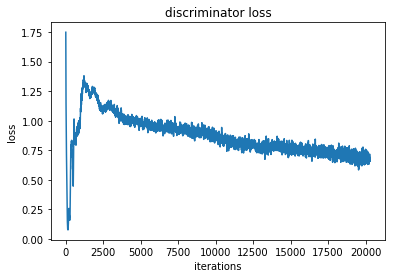

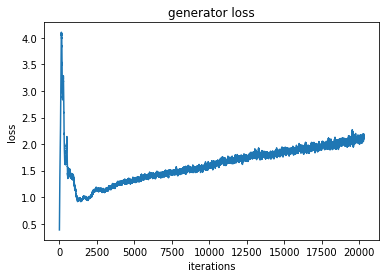

Iteration 20350/23430: dis loss = 0.9062, gen loss = 1.2653
Iteration 20400/23430: dis loss = 0.6697, gen loss = 1.4655
Iteration 20450/23430: dis loss = 0.5329, gen loss = 2.3907
Iteration 20500/23430: dis loss = 0.4833, gen loss = 2.0942
Iteration 20550/23430: dis loss = 0.5142, gen loss = 1.5079
Iteration 20600/23430: dis loss = 0.4318, gen loss = 3.5917
Iteration 20650/23430: dis loss = 0.5031, gen loss = 1.5782
Iteration 20700/23430: dis loss = 0.7109, gen loss = 2.8149
Iteration 20750/23430: dis loss = 0.5455, gen loss = 1.9061
Iteration 20800/23430: dis loss = 0.6123, gen loss = 1.5401
Iteration 20850/23430: dis loss = 0.6423, gen loss = 3.5949
Iteration 20900/23430: dis loss = 0.7624, gen loss = 1.3118
Iteration 20950/23430: dis loss = 0.5510, gen loss = 2.5073
Iteration 21000/23430: dis loss = 0.5863, gen loss = 1.5115
Iteration 21050/23430: dis loss = 0.4347, gen loss = 2.0566
Iteration 21100/23430: dis loss = 1.3715, gen loss = 0.5141
Iteration 21150/23430: dis loss = 0.6306

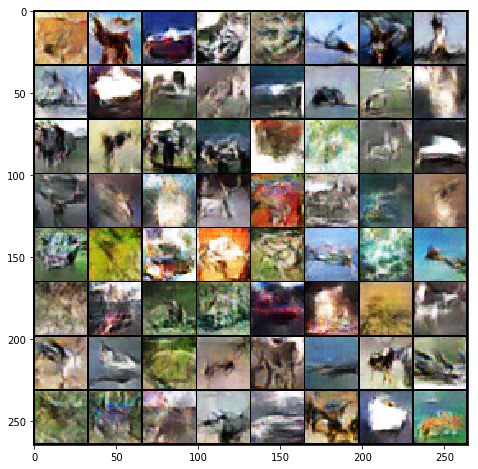

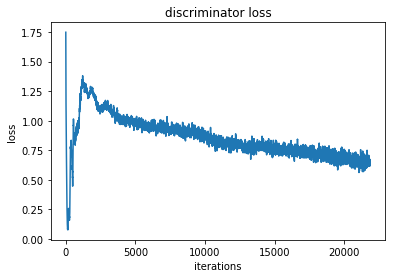

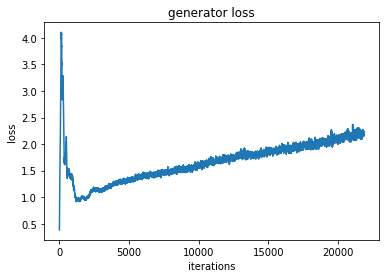

Iteration 21900/23430: dis loss = 0.8310, gen loss = 3.7006
Iteration 21950/23430: dis loss = 0.6486, gen loss = 2.6816
Iteration 22000/23430: dis loss = 0.7170, gen loss = 2.9793
Iteration 22050/23430: dis loss = 0.8842, gen loss = 1.1981
Iteration 22100/23430: dis loss = 1.3400, gen loss = 0.6221
Iteration 22150/23430: dis loss = 0.5250, gen loss = 2.2824
Iteration 22200/23430: dis loss = 0.6747, gen loss = 2.1017
Iteration 22250/23430: dis loss = 0.6166, gen loss = 2.4031
Iteration 22300/23430: dis loss = 0.5939, gen loss = 2.0119
Iteration 22350/23430: dis loss = 0.8595, gen loss = 3.5621
Iteration 22400/23430: dis loss = 0.7515, gen loss = 2.4309
Iteration 22450/23430: dis loss = 1.0837, gen loss = 0.7123
Iteration 22500/23430: dis loss = 0.6698, gen loss = 1.2379
Iteration 22550/23430: dis loss = 0.4122, gen loss = 2.6164
Iteration 22600/23430: dis loss = 0.5167, gen loss = 2.0844
Iteration 22650/23430: dis loss = 0.6911, gen loss = 2.8435
Iteration 22700/23430: dis loss = 0.5711

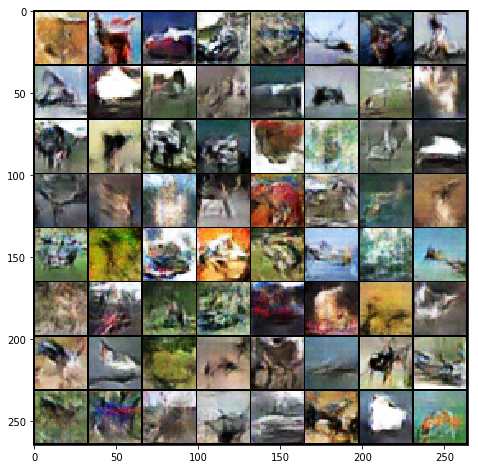

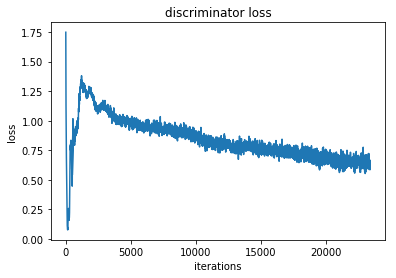

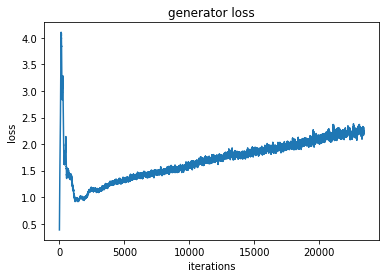

... Done!


In [59]:
tf.reset_default_graph()
set_seed(21)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')

## Problem 2-2: Activation Maximization (10 pts)

GANs notoriously difficult to debug. Here we provide one of methods that are designed for investigating what networks learn, which can be helpful for debugging GANs.

Activation Maximization is a visualization technique to see what a particular neuron has learned, by finding the input that maximizes the activation of that neuron. Here we use methods similar to *[Synthesizing the preferred inputs for neurons in neural networks via deep generator networks](https://arxiv.org/abs/1605.09304)*.

In short, what we want to do is to find the samples that the discriminator considers most real, among all possible outputs of the generator, which is to say, we want to find the codes (i.e. a point in the input space of the generator) from which the generated images, if labelled as real, would minimize the classification loss of the discriminator:

$$\min_{z} L(D_{\theta}(G_{\phi}(z)), 1)$$

Compare this to the objective when we were training the generator:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

The function to minimize is the same, with the difference being that when training the network we fix a set of input data and find the optimal model parameters, while in activation maximization we fix the model parameters and find the optimal input.

So, similar to the training, we use gradient descent to solve for the optimal input. Starting from a random code drawn from a standard normal distribution, we perform a fixed step of Adam optimization algorithm on the code.

The batch normalization layers should work in evaluation mode.

We provide the code for this part, as a reference for solving the next part. You may want to go back to the code above and check the following:

*   **Build the computation graph for the loss:** Check the definition of these operations in ```_init_ops()```
    *   ```actmax_sample_op```: generate samples from ```actmax_code```
    *   ```actmax_loss_op```: compute discriminator's loss on samples generated from ```actmax_code```
*   **Define the optimizer:** Check the definition of ```actmax_op```, which updates ```actmax_code```
*   **Feed the data:** Check the function ```actmax_one_sample()```

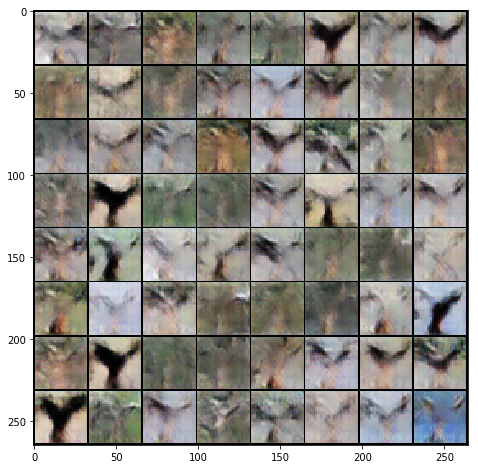

In [60]:
tf.reset_default_graph()
set_seed(241)

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

The output should have less variety than those generated from random code. While it is reasonable that the samples that are "most real" makes up only a small portion of the sample space, this also gives us a hint that the so-called "mode collapse", in which the GAN simply fails to model a majority part of the data distribution, is a real problem.

A similar technique can be used to reconstruct a test sample, that is, to find the code that most closely approximates the test sample. To achieve this, we only need to change the loss function from discriminator's loss to the squared L2-distance between the generated image and the target image:

$$\min_{z} \left|\left|G_{\phi}(z)-x\right|\right|_2^2$$

This time, we always start from a zero vector.

For this part, you need to complete code blocks marked with "Prob 2-2":

*   **Build the computation graph for the loss:** Complete the definition of ```recon_loss_op``` in ```_init_ops()```, which computes the squared L2-distance between ```recon_sample``` and the sample generated from ```actmax_code```.
*   **Define the optimizer:** Modify the definition of ```reconstruct_op``` so that it updates ```actmax_code``` rather than the parameters of the networks.
*   **Feed the data:** Set the proper initial value and feed the proper data in ```reconstruct_one_sample()```

average reconstruction loss = 25.5764


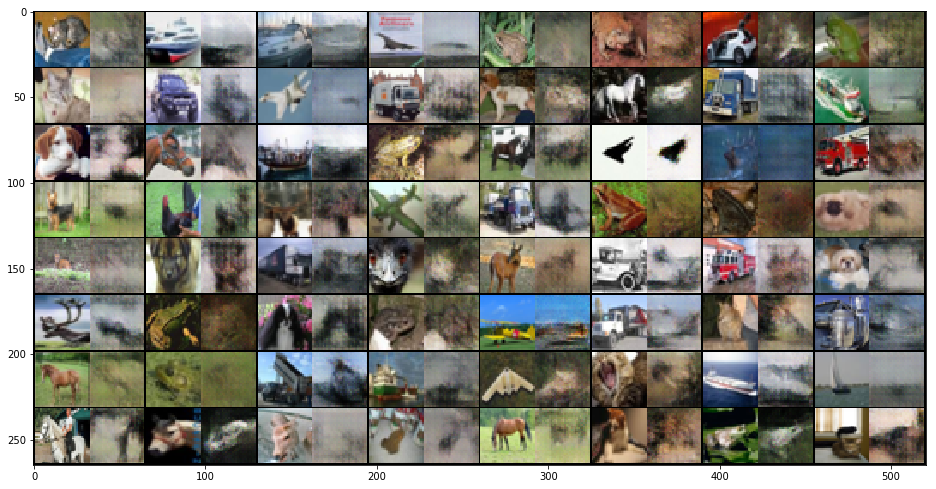

In [61]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[0:64])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (16, 16))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(np.concatenate((test_samples[0:64], reconstructions), axis=2), 1))
        plt.show()

Now you can see the effect of increasing the training epochs. You should be able to achieve a reconstruction loss lower than 32.